## GPR - 2dim Data / Gaussian / Exact

I tried to create a simplified version of this example with artifitial data:

https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/gaussian_processes/GP-Kron.html

You can also find a lot splendid examples from here:

https://www.pymc.io/projects/docs/en/v3/nb_examples/index.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from toygp import gp, kernels

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
jax.config.update('jax_enable_x64', True)

## Generate Keys

In [4]:
keys = jax.random.split(jax.random.PRNGKey(1), num=10)

## Define Grid

In [5]:
# Number of Observation Points
num_x0_pts = 50
num_x1_pts = 40

# Number of Observation Data
num_data = num_x0_pts * num_x1_pts

In [6]:
x0_min, x0_max = 0, 5
x1_min, x1_max = 0, 4

x0 = np.linspace(x0_min, x0_max, num_x0_pts)
x1 = np.linspace(x1_min, x1_max, num_x1_pts)

x0_grid, x1_grid = np.meshgrid(x0, x1)

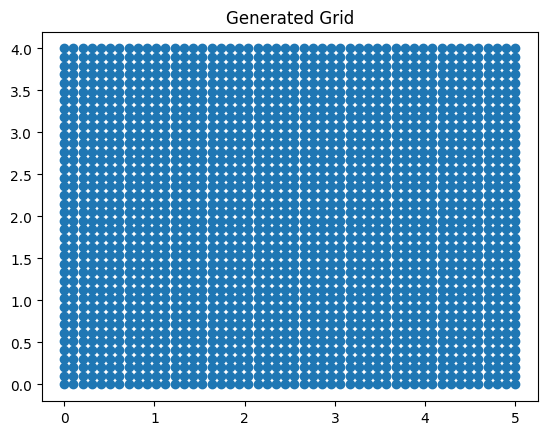

In [7]:
plt.scatter(x0_grid, x1_grid)
plt.title('Generated Grid')
plt.show()

## Generate Data

In [8]:
# Use Capital for Matrix
X0 = x0.reshape(-1, 1)
X1 = x1.reshape(-1, 1)

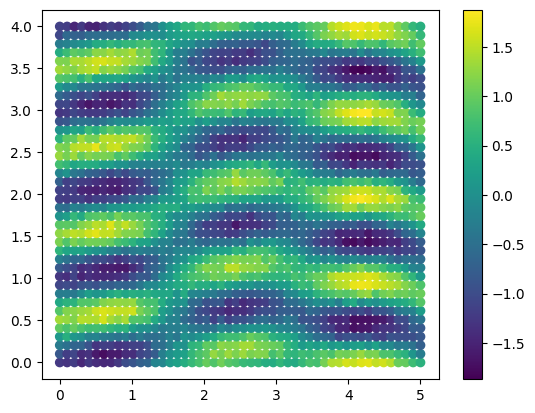

In [9]:
jitter = 1.0e-6

r0_true = 0.8
r1_true = 1.0

kf0 = lambda x0, x1: kernels.rbf(x0, x1, r0_true)
kf1 = lambda x0, x1: kernels.cosine(x0, x1, r1_true)

W0 = gp.cov_factor_exact(kf0, X0, jitter)
W1 = gp.cov_factor_exact(kf1, X1, jitter)

v = dist.Normal(0, 1).sample(keys[0], sample_shape=(num_data,))
f_true = gp.kron_prod(W0, W1, v)

noise_sd = 0.1
y = dist.Normal(f_true, noise_sd).sample(jax.random.PRNGKey(0))

plt.scatter(x0_grid, x1_grid, c=y)
plt.colorbar()
plt.show()

## Define Model

In [10]:
def model(X0, X1, y=None, num_data=0):
    
    num_data = X0.shape[0] * X1.shape[0]
    jitter = 1.0e-6

    #
    # Define Kernel Function
    #

    r0 = numpyro.sample('r0', dist.Gamma(2, 1))
    r1 = numpyro.sample('r1', dist.Gamma(2, 1))
    var = numpyro.sample('var', dist.HalfCauchy(10))
    
    kf0 = lambda x0, x1 : var * kernels.rbf(x0, x1, r0)
    kf1 = lambda x0, x1 : kernels.cosine(x0, x1, r1)

    #
    # Define Gaussian Process
    #

    v = numpyro.sample('v', dist.Normal(0, 1), sample_shape=(num_data,))
    
    W0 = gp.cov_factor_exact(kf0, X0, jitter)
    W1 = gp.cov_factor_exact(kf1, X1, jitter)
    
    f = numpyro.deterministic('f', gp.kron_prod(W0, W1, v))

    #
    # Set Observed Data
    #

    noise_sd = numpyro.sample('noise_sd', dist.HalfNormal(10))
    
    with numpyro.plate('data', num_data):

        numpyro.sample('obs', dist.Normal(f, noise_sd), obs=y)

## Inference

In [11]:
guide = numpyro.infer.autoguide.AutoNormal(model)
#guide = numpyro.infer.autoguide.AutoDiagonalNormal(model)
#guide = numpyro.infer.autoguide.AutoMultivariateNormal(model)

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())

In [12]:
%%time
svi_result = svi.run(keys[1], 5000, X0=X0, X1=X1, y=y, num_data=num_data)

100%|██████████| 5000/5000 [03:00<00:00, 27.73it/s, init loss: 8145.2712, avg. loss [4751-5000]: -1396.8283]


CPU times: user 5min 2s, sys: 11min 16s, total: 16min 19s
Wall time: 3min 3s


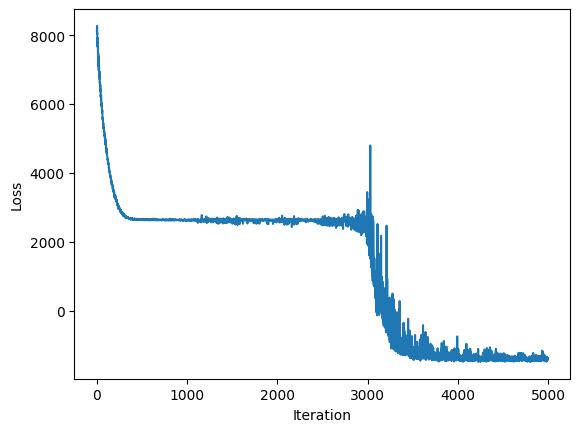

In [13]:
plt.plot(svi_result.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Check Samples

To use arviz's visualization, posterior samples are generated as (2, 1000) to mimic 2-chain MCMC-samples.

In [14]:
posterior_samples = guide.sample_posterior(keys[2], svi_result.params, sample_shape=(2, 1000))
idata = az.from_dict(posterior_samples)

In [15]:
az.summary(idata, var_names=['var', 'r0', 'r1', 'noise_sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var,0.052,0.000,0.052,0.053,0.0,0.0,1969.0,1411.0,1.0
r0,0.679,0.001,0.676,0.681,0.0,0.0,1836.0,1710.0,1.0
r1,0.999,0.000,0.998,1.000,0.0,0.0,1749.0,1925.0,1.0
noise_sd,0.103,0.002,0.100,0.106,0.0,0.0,1847.0,1814.0,1.0


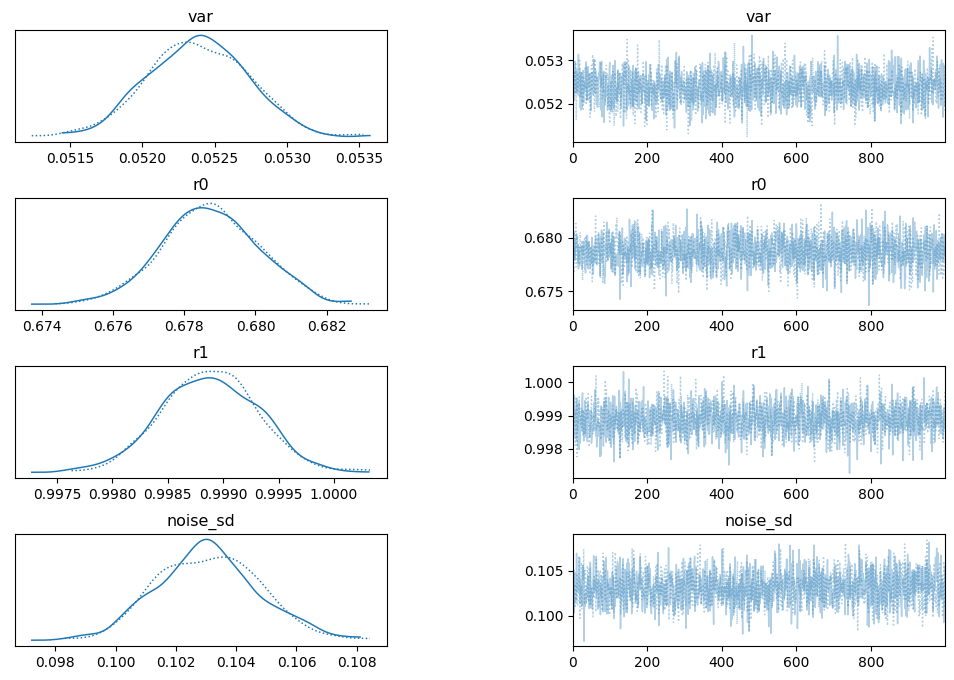

In [16]:
az.plot_trace(idata, var_names=['var', 'r0', 'r1', 'noise_sd'])
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Posterior Predictive

In [17]:
posterior_samples = guide.sample_posterior(keys[3], svi_result.params, sample_shape=(1000,))
predictive = numpyro.infer.Predictive(model, posterior_samples)
predictive_samples = predictive(keys[4], X0=X0, X1=X1, num_data=num_data)

In [18]:
f_mean = np.mean(predictive_samples['f'], axis=0)

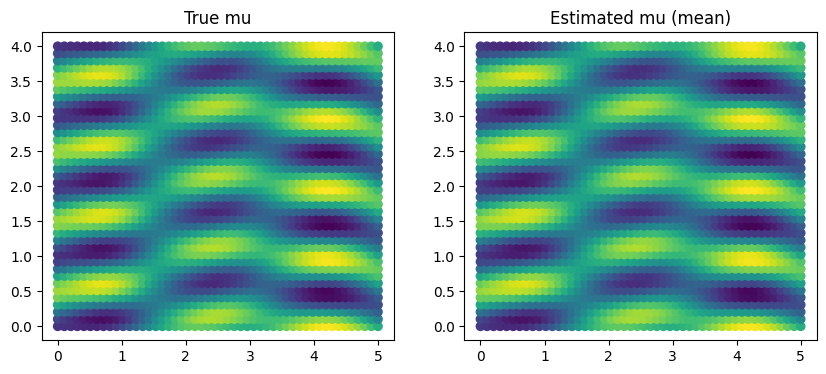

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(x0_grid, x1_grid, c=f_true)
axes[0].set_title('True mu')

axes[1].scatter(x0_grid, x1_grid, c=f_mean)
axes[1].set_title('Estimated mu (mean)')

plt.show()